### Import Library

In [1]:
import pandas as pd
import numpy as np
import os
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import math

from linearmodels import PanelOLS
from linearmodels import PooledOLS
from linearmodels import RandomEffects
from linearmodels.panel.results import compare
from linearmodels.iv import IV2SLS

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

import numpy.linalg as la
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import kstest
from scipy.stats import chi2


pd.set_option('display.max_rows',None, 'display.max_columns',None,'display.max_colwidth', None)

### Read Data

In [23]:
ResInv = pd.read_csv('FinalVariables.csv')
ResInv.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1_x', 'Unnamed: 0.1.1_x',
       'Unnamed: 0.1.1.1_x', 'Unnamed: 0.1.1.1.1_x', 'Unnamed: 0.1.1.1.1.1_x',
       'Unnamed: 0.1.1.1.1.1.1_x', 'Unnamed: 0.1.1.1.1.1.1.1_x',
       'Unnamed: 0.1.1.1.1.1.1.1.1_x', 'Unnamed: 0.1.1.1.1.1.1.1.1.1_x',
       ...
       'ResInv2011', 'ResInv2012', 'ResInv2013', 'ResInv2014', 'ResInv2015',
       'ResInv2016', 'ResInv2017', 'ResInv2018', 'ResInv2019', 'ResInv2020'],
      dtype='object', length=377)

- **Calculate Residential investment per landarea**

In [24]:
# Scale for land area
for row in ResInv:
    if row.startswith('ResInv2'):
        ResInv[row[:-4]+'_PerLandArea_'+row[-4:]] = ResInv[row]/ResInv['LandArea']

- **Sum Residential In a NPA from 2010 to 2020**

In [25]:
investments= []
for var in ResInv: 
    if var.startswith('ResInv20'):
        investments.append(var)
print(investments)
ResInv['InvestmentPerHU'] = ResInv[investments].sum(axis = 1)        

['ResInv2010', 'ResInv2011', 'ResInv2012', 'ResInv2013', 'ResInv2014', 'ResInv2015', 'ResInv2016', 'ResInv2017', 'ResInv2018', 'ResInv2019', 'ResInv2020']


 - **Sum Residential Investments per landarea In a NPA from 2010 to 2020**

In [26]:
investments= []
for var in ResInv: 
    if var.startswith('ResInv_PerLandArea'):
        investments.append(var)
print(investments)
ResInv['InvestmentPerLandAreaHU'] = ResInv[investments].sum(axis = 1)        

['ResInv_PerLandArea_2010', 'ResInv_PerLandArea_2011', 'ResInv_PerLandArea_2012', 'ResInv_PerLandArea_2013', 'ResInv_PerLandArea_2014', 'ResInv_PerLandArea_2015', 'ResInv_PerLandArea_2016', 'ResInv_PerLandArea_2017', 'ResInv_PerLandArea_2018', 'ResInv_PerLandArea_2019', 'ResInv_PerLandArea_2020']


In [27]:
# Scale income by dividing by 1000

# for row in ResInv:
#     if row.startswith('MHIncome'):
#         ResInv[row] = ResInv[row]/1000

- **Calculate Vacant parcels per land area**

In [28]:
#Scale for landrea

for row in ResInv:
    if row.startswith('Vacant'):
        ResInv[row[:-4]+'_PerLandArea_'+row[-4:]] = ResInv[row]/ResInv['LandArea']

- **Calculate housing investments per housing units, use the previous years to normalize** 

In [29]:
# scale for housing units

Years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

for year in Years:
    print(year,year+1)
    ResInv['ResInvPerHousingUnits'+str(year)] = (ResInv['ResInv'+str(year+1)]/ResInv['HousingUnits'+str(year)])*100

2010 2011
2011 2012
2012 2013
2013 2014
2014 2015
2015 2016
2016 2017
2017 2018
2018 2019
2019 2020


In [30]:
Years = [2020]

for year in Years:
    print(year,year+1)
    ResInv['ResInvPerHousingUnits'+str(year)] = ResInv['ResInv'+str(year)]/ResInv['HousingUnits'+str(year)]

2020 2021


- **Calculate Residential Renovations Per Housing Unit**

In [31]:
#scale for housing units
Years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

for year in Years:
    print(year)
    ResInv['ResRenoPerHousingUnits'+str(year)] = (ResInv['ResReno'+str(year)]/ResInv['HousingUnits'+str(year)])*100

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


### Education Interpolation 
- **US Census Bureau doesn't have Education attainment for the years 2010 and 2011 so use 2012 figures**

In [32]:
ResInv['PercentAdultsWithAtLeastBachelors2010'] = ResInv['PercentAdultsWithAtLeastBachelors2012']
ResInv['PercentAdultsWithAtLeastBachelors2011'] = ResInv['PercentAdultsWithAtLeastBachelors2012']

### Compute ResInvestment 

- **Compute Sum of Investments 5 year range**

- Renovations per housing unit

In [33]:
ResInv['Reno2010_2014'] = ResInv[['ResReno2010','ResReno2011','ResReno2012','ResReno2013','ResReno2014' ]].sum(axis = 1)
ResInv['Reno2015_2019'] = ResInv[['ResReno2015','ResReno2016','ResReno2017','ResReno2018','ResReno2019' ]].sum(axis = 1) 

In [34]:
ResInv['RenoHU2010_2014'] = (ResInv[['ResReno2010','ResReno2011','ResReno2012','ResReno2013','ResReno2014' ]].sum(axis = 1)/
                            ResInv['HousingUnits2010'])

ResInv['RenoHU2015_2019'] = (ResInv[['ResReno2015','ResReno2016','ResReno2017','ResReno2018','ResReno2019' ]].sum(axis = 1)/
                            ResInv['HousingUnits2015']) 

- Change in Percent Ownership for 5 years

In [35]:
ResInv['Ownership2012_2017'] = ((ResInv['PercentOwnerOccupied2017'] - ResInv['PercentOwnerOccupied2012'])
                                /ResInv['PercentOwnerOccupied2012'])
# ResInv['Ownership2015_2019'] = ((ResInv['PercentOwnerOccupied2019'] - ResInv['PercentOwnerOccupied2015'])/
#                                 ResInv['PercentOwnerOccupied2015'])

- Buildings 30 years and over

In [36]:
ResInv['Per30Years2012_2017'] = ((ResInv['Percent30Years2017'] - ResInv['Percent30Years2012'])/ResInv['Percent30Years2012'])
# ResInv['Per30Years2015_2019'] = ((ResInv['Percent30Years2019'] - ResInv['Percent30Years2015'])/ResInv['Percent30Years2015'])

- Median Household Income

In [37]:
ResInv['Inc2012_2017'] = ((ResInv['MHIncome2017'] - ResInv['MHIncome2012'])/ResInv['MHIncome2012'])
# ResInv['Inc2015_2019'] = ((ResInv['MHIncome2019'] - ResInv['MHIncome2015'])/ResInv['MHIncome2015'])

- Race

In [38]:
ResInv['White2012_2017'] = ((ResInv['PercentWhite2017'] - ResInv['PercentWhite2012'])/ResInv['PercentWhite2012'])
# ResInv['White2015_2019'] = ((ResInv['PercentWhite2019'] - ResInv['PercentWhite2015'])/ResInv['PercentWhite2015'])

In [39]:
ResInv['Black2012_2017'] = ((ResInv['PercentBlack2017'] - ResInv['PercentBlack2012'])/ResInv['PercentBlack2012'])
# ResInv['Black2015_2019'] = ((ResInv['PercentBlack2019'] - ResInv['PercentBlack2015'])/ResInv['PercentBlack2015'])

In [40]:
ResInv['Hispanic2012_2017'] = ((ResInv['PercentHispanic2017'] - ResInv['PercentHispanic2012'])/ResInv['PercentHispanic2012'])
# ResInv['Hispanic2015_2019'] = ((ResInv['PercentHispanic2019'] - ResInv['PercentHispanic2015'])/ResInv['PercentHispanic2015'])

 ### Percent Change
 - **Calcuate percentage change for the explanatory variables between 2010 and 2020**

In [41]:
ResInv['PercentMinority_Change_2010_2020'] = ((ResInv['PercentMinority2020'] - ResInv['PercentMinority2010'])/
                                              ResInv['PercentMinority2010'])


ResInv['PercentWhite_Change_2010_2020'] = ((ResInv['PercentWhite2020'] - ResInv['PercentWhite2010'])/
                                              ResInv['PercentWhite2010'])

ResInv['PercentBlack_Change_2010_2020'] = ((ResInv['PercentBlack2020'] - ResInv['PercentBlack2010'])/
                                              ResInv['PercentBlack2010'])

ResInv['PercentAdultsWithAtLeastBachelors_Change_2010_2020'] = ((ResInv['PercentAdultsWithAtLeastBachelors2020'] - 
                                                                 ResInv['PercentAdultsWithAtLeastBachelors2012'])/
                                              ResInv['PercentAdultsWithAtLeastBachelors2012'])

ResInv['MedianIncome_Change_2010_2020'] = ((ResInv['MHIncome2020'] - ResInv['MHIncome2010'])/ResInv['MHIncome2010'])


ResInv['Vacant_Change_2010_2020'] = ((ResInv['Vacant2020'] - ResInv['Vacant2010'])/ResInv['Vacant2010'])


ResInv['PercentOwnerOccupied_Change_2010_2020'] = ((ResInv['PercentOwnerOccupied2010'] - ResInv['PercentOwnerOccupied2020'])
                                                  /ResInv['PercentOwnerOccupied2020'])


### Filter Columns for Melting 

In [42]:
Inv = [row for row in ResInv if row.startswith('ResInv2')]
PercentBlack = [row for row in ResInv if row.startswith('PercentBlack2')]
PercentWhite = [row for row in ResInv if row.startswith('PercentWhite2')]
PercentAsian = [row for row in ResInv if row.startswith('PercentAsian2')]
PercentHispanic = [row for row in ResInv if row.startswith('PercentHispanic2')]
PercentHawaiian = [row for row in ResInv if row.startswith('PercentHawaiian2')]
PercentAlaska = [row for row in ResInv if row.startswith('PercentAlaska2')]
PercentSomeOther = [row for row in ResInv if row.startswith('PercentSomeOther2')]
PercentTwoorMore = [row for row in ResInv if row.startswith('PercentTwoorMore2')]
PercentMinority = [row for row in ResInv if row.startswith('PercentMinority2')]
PercentOwnerOccupied = [row for row in ResInv if row.startswith('PercentOwnerOccupied2')]
MHIncome = [row for row in ResInv if row.startswith('MHIncome2')]
PercentAdultsWithAtLeastBachelors = [row for row in ResInv if row.startswith('PercentAdultsWithAtLeastBachelors2')]
PerLandArea = [row for row in ResInv if row.startswith('ResInv_PerLandArea')]
PerHousingUnit = [row for row in ResInv if row.startswith('ResInvPerHousingUnits')]
Vacant = [row for row in ResInv if row.startswith('Vacant2')]
VacantPerLandArea = [row for row in ResInv if row.startswith('Vacant_PerLandArea')]
SingleFam = [row for row in ResInv if row.startswith('Sing')]
MultiFam = [row for row in ResInv if row.startswith('Mul')]
Percent30Years = [row for row in ResInv if row.startswith('Percent30Years')]
ResReno = [row for row in ResInv if row.startswith('ResReno2')]
ResRenoHousing = [row for row in ResInv if row.startswith('ResRenoPerHousingUnits')]
HousingUnits = [row for row in ResInv if row.startswith('HousingUnits')]
AverageAge = [row for row in ResInv if row.startswith('AverageYearBuilt2')]
NetBldValue = [row for row in ResInv if row.startswith('NetBldgVal2')]
SalesPrice = [row for row in ResInv if row.startswith('Price2')]
SingleFamilyUnits = [row for row in ResInv if row.startswith('SFUnits2')]

### Melt Data for each Individual Category

In [43]:
InvRes = pd.melt(ResInv, id_vars= 'NPA', value_vars=Inv, value_name='ResInvestments') 
Blacks = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentBlack, value_name='PercentBlack') 
Whites = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentWhite, value_name='PercentWhite') 
Asians = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentAsian, value_name='PercentAsian') 
Hispanic = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentHispanic, value_name='PercentHispanic') 
Hawaiian = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentHawaiian, value_name='PercentHawaiian') 
Alaska = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentAlaska, value_name='PercentAlaska') 
SomeOther = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentSomeOther, value_name='PercentSomeOther') 
Mixed = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentTwoorMore, value_name='PercentTwoorMore') 
Minority = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentMinority, value_name='PercentMinority') 
Ownership = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentOwnerOccupied, value_name='PercentOwnerOccupied') 
Income = pd.melt(ResInv, id_vars= 'NPA', value_vars=MHIncome, value_name='MHIncome') 
Education = pd.melt(ResInv, id_vars= 'NPA', value_vars=PercentAdultsWithAtLeastBachelors, value_name='EducationAttainment') 
ResPerLandArea = pd.melt(ResInv, id_vars= 'NPA', value_vars=PerLandArea, value_name='ResInvPerLandArea') 
VacantPerLA = pd.melt(ResInv, id_vars= 'NPA', value_vars=VacantPerLandArea, value_name='VacantPerLandArea') 
VacantShare= pd.melt(ResInv, id_vars= 'NPA', value_vars=Vacant, value_name='Vacant') 
SingleFam = pd.melt(ResInv, id_vars= 'NPA', value_vars=SingleFam, value_name='SingleFam') 
MultiFam = pd.melt(ResInv, id_vars= 'NPA', value_vars=MultiFam, value_name='MultiFam') 
ResPerHousingUnit = pd.melt(ResInv, id_vars= 'NPA', value_vars=PerHousingUnit, value_name='ResInvPerHousingUnit') 
PercentBuilding30Years = pd.melt(ResInv, id_vars= 'NPA', value_vars=Percent30Years, value_name='PercentBuildings30YrsPlus') 
ResRenovations = pd.melt(ResInv, id_vars= 'NPA', value_vars=ResReno, value_name='ResRenovations') 
ResRenovationsHousing = pd.melt(ResInv, id_vars= 'NPA', value_vars=ResRenoHousing, value_name='ResRenoPerHousingUnit') 
Housing = pd.melt(ResInv, id_vars= 'NPA', value_vars=HousingUnits, value_name='HousingUnits')
YearBuilt = pd.melt(ResInv, id_vars= 'NPA', value_vars=AverageAge, value_name='AverageYearBuilt')
NetBuildingValue = pd.melt(ResInv, id_vars= 'NPA', value_vars=NetBldValue, value_name='NetBuildingValue')
MedianSalesPrice = pd.melt(ResInv, id_vars= 'NPA', value_vars=SalesPrice, value_name='MedianSalesPrice')
SFHousingUnits = pd.melt(ResInv, id_vars= 'NPA', value_vars=SingleFamilyUnits, value_name='SFUnits')


- **Make sure at the indivual dataframes have the same shape**

In [45]:
InvRes.shape,Blacks.shape,Whites.shape,Asians.shape,Hispanic.shape,Hawaiian.shape,Alaska.shape,SomeOther.shape,Mixed.shape,Minority.shape,Ownership.shape,Income.shape,Education.shape,MultiFam.shape,SingleFam.shape,VacantShare.shape,VacantPerLA.shape,ResPerHousingUnit.shape,PercentBuilding30Years.shape,ResRenovations.shape,ResRenovationsHousing.shape,Housing.shape,YearBuilt.shape,NetBuildingValue.shape,MedianSalesPrice.shape,SFHousingUnits.shape

((4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3),
 (4246, 3))

### Extract Year Variable from Columns

In [46]:
InvRes['Year'] = [int(row[-4:]) for row in InvRes['variable']]
ResPerLandArea['Year'] = [int(row[-4:]) for row in ResPerLandArea['variable']]
ResPerHousingUnit['Year'] =  [int(row[-4:]) for row in ResPerHousingUnit['variable']]

Blacks['Year'] = [int(row[-4:]) for row in Blacks['variable']]
Whites['Year'] = [int(row[-4:]) for row in Whites['variable']]
Asians['Year'] = [int(row[-4:]) for row in Asians['variable']]
Hispanic['Year'] = [int(row[-4:]) for row in Hispanic['variable']]
Hawaiian['Year'] = [int(row[-4:]) for row in Hawaiian['variable']]
SomeOther['Year'] = [int(row[-4:]) for row in SomeOther['variable']]
Mixed['Year'] = [int(row[-4:]) for row in Mixed['variable']]
Minority['Year'] = [int(row[-4:]) for row in Minority['variable']]

Ownership['Year'] = [int(row[-4:]) for row in Ownership['variable']]

Income['Year'] = [int(row[-4:]) for row in Income['variable']]

Education['Year'] = [int(row[-4:]) for row in Education['variable']]

VacantShare['Year'] = [int(row[-4:]) for row in VacantShare['variable']]
VacantPerLA['Year'] = [int(row[-4:]) for row in VacantPerLA['variable']]


SingleFam['Year'] = [int(row[-4:]) for row in SingleFam['variable']]

MultiFam['Year'] = [int(row[-4:]) for row in MultiFam['variable']]

PercentBuilding30Years['Year'] = [int(row[-4:]) for row in PercentBuilding30Years['variable']]

ResRenovations['Year'] = [int(row[-4:]) for row in ResRenovations['variable']]

ResRenovationsHousing['Year'] = [int(row[-4:]) for row in ResRenovationsHousing['variable']]

Housing['Year'] = [int(row[-4:]) for row in Housing['variable']]

YearBuilt['Year'] = [int(row[-4:]) for row in YearBuilt['variable']]

NetBuildingValue['Year'] = [int(row[-4:]) for row in NetBuildingValue['variable']]

MedianSalesPrice['Year'] = [int(row[-4:]) for row in MedianSalesPrice['variable']]

SFHousingUnits['Year'] = [int(row[-4:]) for row in SFHousingUnits['variable']]

### Create a Panel

In [47]:
PanelDataFrame = [InvRes,Blacks,Whites,Asians,Hispanic,Hawaiian,SomeOther,Mixed,Minority,Ownership,PercentBuilding30Years,
                  Income,Education,ResPerLandArea,VacantShare,SingleFam,Housing,YearBuilt,NetBuildingValue,MedianSalesPrice,
                  MultiFam,VacantPerLA,ResPerHousingUnit,ResRenovations,ResRenovationsHousing,SFHousingUnits]

len(PanelDataFrame)

26

### Join all dataframes 

In [48]:
Panel = reduce(lambda right,left: pd.merge(right, left, on = ['NPA', 'Year'], how = 'left'), PanelDataFrame)

In [53]:
Panel = Panel.drop_duplicates(subset=['NPA','Year'])

In [54]:
# Panel = Panel[Panel['Year']!=2020]

In [55]:
# Pan el = Panel[Panel['ResRenovations']>10]

- **Delete Unwanted Variable Column**

- **Set Index**

In [57]:
Panel.set_index(['NPA', 'Year'], inplace=True)

In [58]:
Panel = Panel.sort_values(by=['NPA','Year'])


- **Check if Panel is Balanced** 

In [59]:
BalancePanel = Panel.groupby('NPA').size()

PanelMin = BalancePanel.min()
PanelMax = BalancePanel.max()
    
BalanceCheck = PanelMin == PanelMax

BalanceCheck

True

### Correlation 

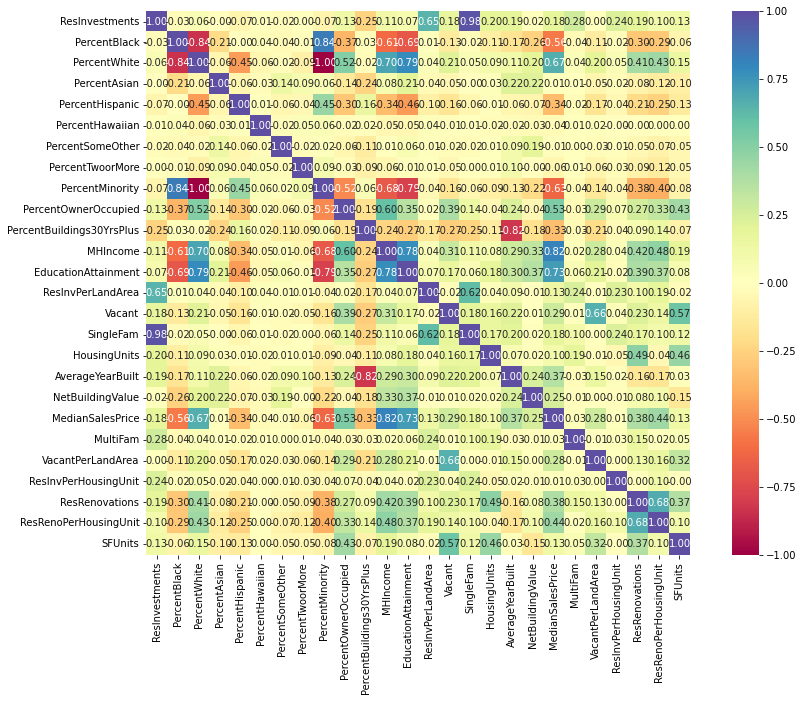

In [61]:
corrmat = Panel.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=1, square=True,fmt= '.2f',annot_kws={'size': 10}, 
            annot= True, cmap="Spectral")
plt.show();

## Regresssion 

In [62]:
Panel.columns

Index(['ResInvestments', 'PercentBlack', 'PercentWhite', 'PercentAsian',
       'PercentHispanic', 'PercentHawaiian', 'PercentSomeOther',
       'PercentTwoorMore', 'PercentMinority', 'PercentOwnerOccupied',
       'PercentBuildings30YrsPlus', 'MHIncome', 'EducationAttainment',
       'ResInvPerLandArea', 'Vacant', 'SingleFam', 'HousingUnits',
       'AverageYearBuilt', 'NetBuildingValue', 'MedianSalesPrice', 'MultiFam',
       'VacantPerLandArea', 'ResInvPerHousingUnit', 'ResRenovations',
       'ResRenoPerHousingUnit', 'SFUnits'],
      dtype='object')

- lag independent variables

In [63]:
### Lag variables 

Initialcol = ResInv.columns

for row in Panel:
    VarLag = 'lag_'+ row
    Panel[VarLag] = Panel.groupby(level='NPA')[row].shift(1)
    
## Replace inf with Nan
    
# Panel.replace([np.inf, -np.inf], np.nan, inplace=True)
Panel.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
# Panel.to_csv('ForStepwise.csv')


## Drop na 


Panel = Panel.dropna()

In [64]:
# for row in Panel:
#     if row.startswith('lag') or row.startswith('ResReno'):
#         Panel[row] = np.log(Panel[row])
        
# Panel.replace([np.inf, -np.inf], np.nan, inplace=True)
# Panel.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
# # Panel = Panel.dropna()

In [65]:
lags = [row for row in Panel if row.startswith('lag')]
lags

['lag_ResInvestments',
 'lag_PercentBlack',
 'lag_PercentWhite',
 'lag_PercentAsian',
 'lag_PercentHispanic',
 'lag_PercentHawaiian',
 'lag_PercentSomeOther',
 'lag_PercentTwoorMore',
 'lag_PercentMinority',
 'lag_PercentOwnerOccupied',
 'lag_PercentBuildings30YrsPlus',
 'lag_MHIncome',
 'lag_EducationAttainment',
 'lag_ResInvPerLandArea',
 'lag_Vacant',
 'lag_SingleFam',
 'lag_HousingUnits',
 'lag_AverageYearBuilt',
 'lag_NetBuildingValue',
 'lag_MedianSalesPrice',
 'lag_MultiFam',
 'lag_VacantPerLandArea',
 'lag_ResInvPerHousingUnit',
 'lag_ResRenovations',
 'lag_ResRenoPerHousingUnit',
 'lag_SFUnits']

### For Renovations

In [66]:
# lags = ['lag_ResRenovations',
# 'lag_PercentWhite',
# 'lag_PercentOwnerOccupied',
# 'lag_PercentBuildings30YrsPlus']

Exogeneous = sm.add_constant(Panel[lags])

In [67]:
lags =[
  'lag_PercentWhite',
   'lag_HousingUnits',
'lag_MHIncome',
 'lag_PercentOwnerOccupied',
 'lag_PercentBuildings30YrsPlus',
 'lag_ResRenovations',
 'lag_NetBuildingValue',
'lag_SFUnits',
'lag_MedianSalesPrice',
]

Exogeneous = sm.add_constant(Panel[lags])

In [68]:
# Panel['ResRenovations'] = np.log(Panel['ResRenovations'])
# Panel.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

### Lasso Regression

In [69]:
Lasso = sm.OLS(Panel.ResRenovations, Exogeneous).fit_regularized(alpha=1.0, L1_wt=1.0)
print(Lasso.params)

const                            0.000000
lag_PercentWhite                 0.028188
lag_HousingUnits                 0.000690
lag_MHIncome                     0.000017
lag_PercentOwnerOccupied        -0.046324
lag_PercentBuildings30YrsPlus    0.006165
lag_ResRenovations               0.633227
lag_NetBuildingValue            -0.000002
lag_SFUnits                      0.004148
lag_MedianSalesPrice             0.000007
dtype: float64


In [70]:
Exogeneous = sm.add_constant(Panel[lags])

### Ridge Regression 

In [71]:
Lasso = sm.OLS(Panel.ResRenovations, Exogeneous).fit_regularized(alpha=1.0, L1_wt=0.0)
# LassoFit = Lasso.fit_regularized(alpha = 1.0, L1_wt=1.0)
print(Lasso.params)

[ 2.46554160e-01  3.15488895e-02  6.45883713e-04  2.07227699e-05
 -5.09038791e-02  4.42613903e-03  6.36951668e-01 -2.49834361e-06
  4.14261088e-03  5.77016908e-06]


### Pooled OLS

In [72]:
### Regression Residential investments Per Land Area on lagged Independent variables
PanelResInvestmentsPOLS = PooledOLS(Panel.ResRenovations, Exogeneous)
PanelfitPOLS = PanelResInvestmentsPOLS.fit()
fitvPOLS = PanelfitPOLS.predict().fitted_values
residPOLS = PanelfitPOLS.resids
print(PanelfitPOLS)

                          PooledOLS Estimation Summary                          
Dep. Variable:         ResRenovations   R-squared:                        0.5763
Estimator:                  PooledOLS   R-squared (Between):              0.9087
No. Observations:                4246   R-squared (Within):              -0.4135
Date:                Mon, Sep 18 2023   R-squared (Overall):              0.5763
Time:                        18:10:41   Log-likelihood                 -1.46e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      640.18
Entities:                         386   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                  F(9,4236)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             640.18
                            

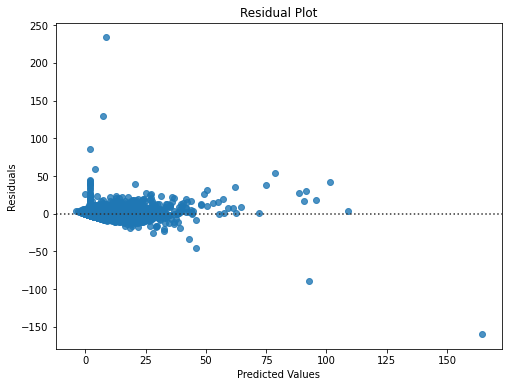

In [73]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=PanelfitPOLS.predict(), y=residPOLS)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

### Fixed Effects

In [74]:
### Regression Residential investments on lagged Independent variables
PanelResInvestmentsFE = PanelOLS(Panel.ResRenovations, Exogeneous, entity_effects=True)
PanelFitFE = PanelResInvestmentsFE.fit(cov_type='clustered', cluster_entity=True)
residPOLSFE = PanelFitFE.resids
print(PanelFitFE)

                          PanelOLS Estimation Summary                           
Dep. Variable:         ResRenovations   R-squared:                        0.0381
Estimator:                   PanelOLS   R-squared (Between):              0.2717
No. Observations:                4246   R-squared (Within):               0.0381
Date:                Mon, Sep 18 2023   R-squared (Overall):              0.2130
Time:                        18:10:49   Log-likelihood                -1.341e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.956
Entities:                         386   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                  F(9,3851)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             9.0001
                            

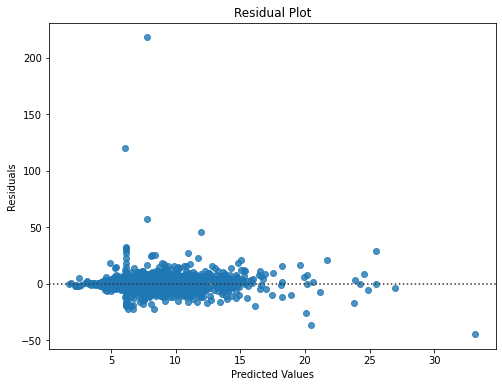

In [75]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=PanelFitFE.predict(), y=residPOLSFE)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

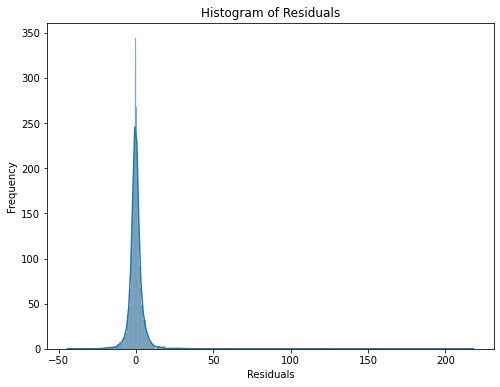

In [76]:
# Histogram of Residuals FE
plt.figure(figsize=(8, 6))
sns.histplot(residPOLSFE, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

### Random Effects

In [77]:
PanelResInvestmentsRE = RandomEffects(Panel.ResRenovations,Exogeneous)
PanelFitRE = PanelResInvestmentsRE.fit()
residPOLSRE = PanelFitRE.resids
print(PanelFitRE)

                        RandomEffects Estimation Summary                        
Dep. Variable:         ResRenovations   R-squared:                        0.5763
Estimator:              RandomEffects   R-squared (Between):              0.9087
No. Observations:                4246   R-squared (Within):              -0.4135
Date:                Mon, Sep 18 2023   R-squared (Overall):              0.5763
Time:                        18:10:57   Log-likelihood                 -1.46e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      640.18
Entities:                         386   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                  F(9,4236)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             640.18
                            

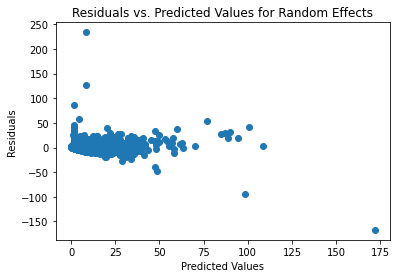

In [51]:
## Random Effects 

plt.scatter(PanelFitRE.predict(), residPOLSRE)
plt.title('Residuals vs. Predicted Values for Random Effects')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

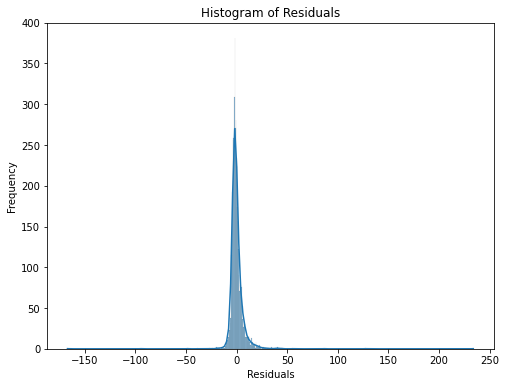

In [52]:
# Histogram of Residuals RE
plt.figure(figsize=(8, 6))
sns.histplot(residPOLSRE, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

### Model Comparison for Fixed and Random Effects

In [53]:
ModelComparison = compare({'Fixed Effects': PanelFitFE, 'Random Effects': PanelFitRE})
print(ModelComparison)

                            Model Comparison                           
                                       Fixed Effects     Random Effects
-----------------------------------------------------------------------
Dep. Variable                         ResRenovations     ResRenovations
Estimator                                   PanelOLS      RandomEffects
No. Observations                                4246               4246
Cov. Est.                                  Clustered         Unadjusted
R-squared                                     0.0346             0.5630
R-Squared (Within)                            0.0346            -0.4467
R-Squared (Between)                           0.2673             0.9021
R-Squared (Overall)                           0.2088             0.5630
F-statistic                                   23.044             910.33
P-value (F-stat)                              0.0000             0.0000
===============================     ================   =========

#### Hausman Test
- The test statistic measures the difference between the estimated coefficients, a value close to zero suggests the coefficients are not significantly different from eachother
- Null Hypothesis is Random Effects is the better model, hence with a lower p value, you can reject the null hypothesis

In [54]:
fe_params = PanelFitFE.params
re_params = PanelFitRE.params
fe_cov_matrix = PanelFitFE.cov
re_cov_matrix = PanelFitRE.cov

beta_diff = fe_params - re_params

# Calculate the Hausman test statistic
hausman_test_statistic = beta_diff.T @ (fe_cov_matrix - re_cov_matrix) @ beta_diff

# Calculate the p-value
degrees_of_freedom = len(fe_params)
p_value = 1 - chi2.cdf(hausman_test_statistic, degrees_of_freedom)

# Print the results
print("Hausman Test Statistic:", hausman_test_statistic)
print("Degrees of Freedom:", degrees_of_freedom)
print("P-value:", p_value)

Hausman Test Statistic: -0.4931796972785968
Degrees of Freedom: 7
P-value: 1.0


#### Baltagi, Song, and Koh Lagrange Multiplier (BSK LM) 

- Null Hypothesis is No Heteroskedasticity, when p value is low it means there is Heteroskedasticity
- Large values for the test statistic indicates stronger evidence of heteroskedasticity

In [55]:
### Fixed Effects

bsk_lm_test_statistic = PanelFitFE.resids.autocorr(1) * (len(Panel) - 1)
bsk_lm_p_value = 1 - chi2.cdf(bsk_lm_test_statistic, 1)
print(f'BSK LM Test Statistic: {bsk_lm_test_statistic}') ## Lower T Statistic Preffered
print(f'BSK LM P-Value: {bsk_lm_p_value}') 

BSK LM Test Statistic: -181.5803969787084
BSK LM P-Value: 1.0


In [56]:
### Fixed Effects

bsk_lm_test_statistic = PanelFitRE.resids.autocorr(1) * (len(Panel) - 1)
bsk_lm_p_value = 1 - chi2.cdf(bsk_lm_test_statistic, 1)
print(f'BSK LM Test Statistic: {bsk_lm_test_statistic}') ## Lower T Statistic Preffered
print(f'BSK LM P-Value: {bsk_lm_p_value}') 

BSK LM Test Statistic: -847.2989081639134
BSK LM P-Value: 1.0


****   

****

****

### For Renovation Per Housing Unit

In [57]:
lags = ['lag_ResInvestments',
 'lag_PercentBlack',
 'lag_PercentWhite',
 'lag_PercentAsian',
 'lag_PercentHispanic',
 'lag_PercentHawaiian',
 'lag_PercentSomeOther',
 'lag_PercentTwoorMore',
 'lag_PercentMinority',
 'lag_PercentOwnerOccupied',
 'lag_PercentBuildings30YrsPlus',
 'lag_MHIncome',
 'lag_EducationAttainment',
 'lag_ResInvPerLandArea',
 'lag_Vacant',
 'lag_SingleFam',
 'lag_MultiFam',
 'lag_VacantPerLandArea',
 'lag_ResInvPerHousingUnit',
 'lag_ResRenovations',
 'lag_ResRenoPerHousingUnit']

Exogeneous = sm.add_constant(Panel[lags])

In [58]:
lags =[
   'lag_PercentWhite',
     'lag_PercentOwnerOccupied',
 'lag_PercentBuildings30YrsPlus',
 'lag_ResRenoPerHousingUnit']

Exogeneous = sm.add_constant(Panel[lags])

### Lasso Regression

In [59]:
Lasso = sm.OLS(Panel.ResRenoPerHousingUnit, Exogeneous).fit_regularized(alpha=1.0, L1_wt=1.0)
print(Lasso.params)

const                            0.000000
lag_PercentWhite                 0.011346
lag_PercentOwnerOccupied         0.003730
lag_PercentBuildings30YrsPlus    0.003017
lag_ResRenoPerHousingUnit        0.000000
dtype: float64


### Pooled OLS

In [60]:
### Regression Residential investments on lagged Independent variables
PanelResInvestmentsPOLS = PooledOLS(Panel.ResRenoPerHousingUnit, Exogeneous)
PanelfitPOLS = PanelResInvestmentsPOLS.fit()
fitvPOLS = PanelfitPOLS.predict().fitted_values
residPOLS = PanelfitPOLS.resids
print(PanelfitPOLS)

                            PooledOLS Estimation Summary                           
Dep. Variable:     ResRenoPerHousingUnit   R-squared:                        0.4165
Estimator:                     PooledOLS   R-squared (Between):              0.8369
No. Observations:                   4246   R-squared (Within):              -0.1864
Date:                   Tue, Sep 12 2023   R-squared (Overall):              0.4165
Time:                           13:54:49   Log-likelihood                   -5376.9
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      756.79
Entities:                            386   P-value                           0.0000
Avg Obs:                          11.000   Distribution:                  F(4,4241)
Min Obs:                          11.000                                           
Max Obs:                          11.000   F-statistic (robust):            

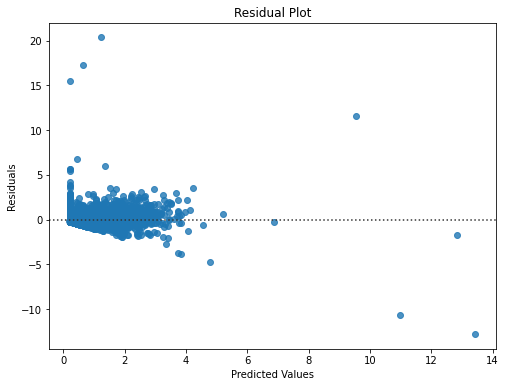

In [61]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=PanelfitPOLS.predict(), y=residPOLS)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

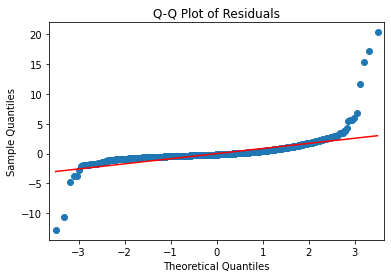

In [62]:
# Normality of residuals (Q-Q plot)
sm.qqplot(residPOLS, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### Fixed Effects

In [63]:
### Regression Residential investments on lagged Independent variables
PanelResInvestmentsFE = PanelOLS(Panel.ResRenoPerHousingUnit, Exogeneous, entity_effects=True)
PanelFitFE = PanelResInvestmentsFE.fit(cov_type='clustered', cluster_entity=True)
residPOLSFE = PanelFitFE.resids
print(PanelFitFE)

                            PanelOLS Estimation Summary                            
Dep. Variable:     ResRenoPerHousingUnit   R-squared:                        0.0443
Estimator:                      PanelOLS   R-squared (Between):              0.2846
No. Observations:                   4246   R-squared (Within):               0.0443
Date:                   Tue, Sep 12 2023   R-squared (Overall):              0.1859
Time:                           13:54:49   Log-likelihood                   -4535.8
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      44.671
Entities:                            386   P-value                           0.0000
Avg Obs:                          11.000   Distribution:                  F(4,3856)
Min Obs:                          11.000                                           
Max Obs:                          11.000   F-statistic (robust):            

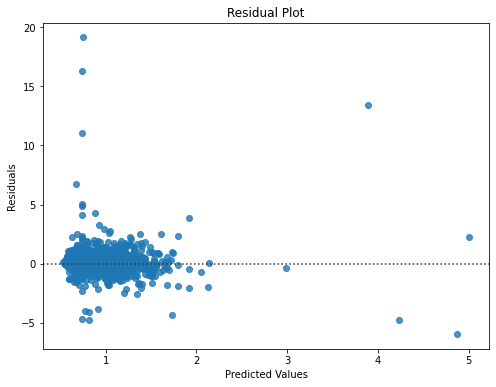

In [64]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=PanelFitFE.predict(), y=residPOLSFE)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

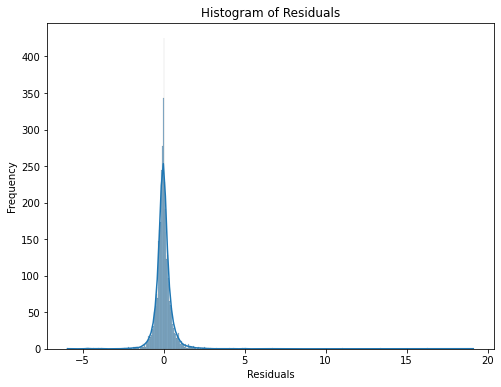

In [65]:
# Histogram of Residuals FE
plt.figure(figsize=(8, 6))
sns.histplot(residPOLSFE, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

### Random Effects

In [66]:
PanelResInvestmentsRE = RandomEffects(Panel.ResRenoPerHousingUnit,Exogeneous)
PanelFitRE = PanelResInvestmentsRE.fit()
residPOLSRE = PanelFitRE.resids
print(PanelFitRE)

                          RandomEffects Estimation Summary                         
Dep. Variable:     ResRenoPerHousingUnit   R-squared:                        0.4165
Estimator:                 RandomEffects   R-squared (Between):              0.8369
No. Observations:                   4246   R-squared (Within):              -0.1864
Date:                   Tue, Sep 12 2023   R-squared (Overall):              0.4165
Time:                           13:54:51   Log-likelihood                   -5376.9
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      756.79
Entities:                            386   P-value                           0.0000
Avg Obs:                          11.000   Distribution:                  F(4,4241)
Min Obs:                          11.000                                           
Max Obs:                          11.000   F-statistic (robust):            

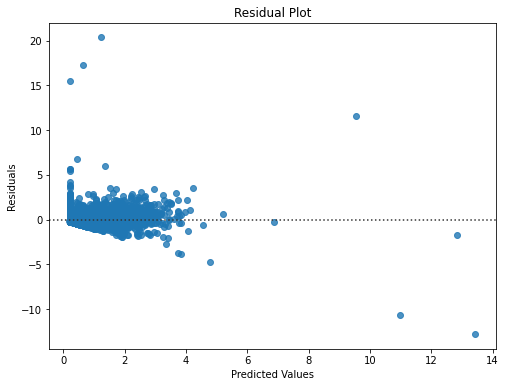

In [67]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=PanelFitRE.predict(), y=residPOLSRE)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

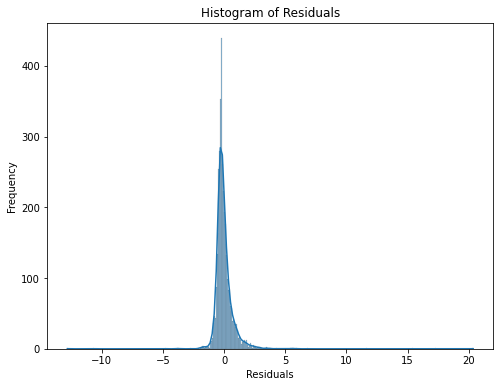

In [68]:
# Histogram of Residuals RE
plt.figure(figsize=(8, 6))
sns.histplot(residPOLSRE, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

### Model Comparison

In [69]:
ModelComparison = compare({'Fixed Effects': PanelFitFE, 'Random Effects': PanelFitRE})
print(ModelComparison )

                                   Model Comparison                                  
                                              Fixed Effects            Random Effects
-------------------------------------------------------------------------------------
Dep. Variable                         ResRenoPerHousingUnit     ResRenoPerHousingUnit
Estimator                                          PanelOLS             RandomEffects
No. Observations                                       4246                      4246
Cov. Est.                                         Clustered                Unadjusted
R-squared                                            0.0443                    0.4165
R-Squared (Within)                                   0.0443                   -0.1864
R-Squared (Between)                                  0.2846                    0.8369
R-Squared (Overall)                                  0.1859                    0.4165
F-statistic                                          4

#### Hausman Test

In [70]:
fe_params = PanelFitFE.params
re_params = PanelFitRE.params
fe_cov_matrix = PanelFitFE.cov
re_cov_matrix = PanelFitRE.cov

beta_diff = fe_params - re_params

# Calculate the Hausman test statistic
hausman_test_statistic = beta_diff.T @ (fe_cov_matrix - re_cov_matrix) @ beta_diff

# Calculate the p-value
degrees_of_freedom = len(fe_params)
p_value = 1 - chi2.cdf(hausman_test_statistic, degrees_of_freedom)

# Print the results
print("Hausman Test Statistic:", hausman_test_statistic)
print("Degrees of Freedom:", degrees_of_freedom)
print("P-value:", p_value)

Hausman Test Statistic: 0.002613806096754963
Degrees of Freedom: 5
P-value: 0.9999999814379122


#### Baltagi, Song, and Koh Lagrange Multiplier (BSK LM) 

In [71]:
### Fixed Effects

bsk_lm_test_statistic = PanelFitFE.resids.autocorr(1) * (len(Panel) - 1)
bsk_lm_p_value = 1 - chi2.cdf(bsk_lm_test_statistic, 1)
print(f'BSK LM Test Statistic: {bsk_lm_test_statistic}') ## Lower T Statistic Preffered
print(f'BSK LM P-Value: {bsk_lm_p_value}')

BSK LM Test Statistic: -88.64478901564149
BSK LM P-Value: 1.0


In [72]:
### Fixed Effects

bsk_lm_test_statistic = PanelFitRE.resids.autocorr(1) * (len(Panel) - 1)
bsk_lm_p_value = 1 - chi2.cdf(bsk_lm_test_statistic, 1)
print(f'BSK LM Test Statistic: {bsk_lm_test_statistic}') ## Lower T Statistic Preffered
print(f'BSK LM P-Value: {bsk_lm_p_value}')

BSK LM Test Statistic: -435.7673188872576
BSK LM P-Value: 1.0


### Variance Inflation Factor

In [73]:
PercentChange = ['PercentWhite_Change_2010_2020','MedianIncome_Change_2010_2020','PercentBlack_Change_2010_2020',
                 'Vacant_Change_2010_2020','PercentOwnerOccupied_Change_2010_2020','PercentMinority_Change_2010_2020',
               'PercentAdultsWithAtLeastBachelors_Change_2010_2020']

In [74]:
VIF = pd.DataFrame(ResInv[PercentChange])
VIF.replace([np.inf, -np.inf,np.nan], 0, inplace=True)

In [75]:
ResInv.replace([np.inf, -np.inf,np.nan], 0, inplace=True)

In [76]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)


In [77]:
calc_vif(VIF).sort_values(by=['VIF'],ascending=False)

,Variable,VIF
5,PercentMinority_Change_2010_2020,1.262199
2,PercentBlack_Change_2010_2020,1.243938
1,MedianIncome_Change_2010_2020,1.213678
3,Vacant_Change_2010_2020,1.151700
0,PercentWhite_Change_2010_2020,1.112399
6,PercentAdultsWithAtLeastBachelors_Change_2010_2020,1.084583
4,PercentOwnerOccupied_Change_2010_2020,1.029328


In [78]:
# PercentChange = ['PercentWhite_Change_2010_2020','MedianIncome_Change_2010_2020','PercentBlack_Change_2010_2020',
#                  'Vacant_Change_2010_2020','PercentOwnerOccupied_Change_2010_2020','PercentMinority_Change_2010_2020',
#                'PercentAdultsWithAtLeastBachelors_Change_2010_2020']

In [79]:
IndependentVariables = ['White2012_2017','Ownership2012_2017','Per30Years2012_2017',
                        'Inc2012_2017']

In [80]:
ResInv['InvestmentPerHU'] = np.log(ResInv['InvestmentPerHU'])

# ResInv

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [81]:
ResInv.replace([np.inf, -np.inf,np.nan], 0, inplace=True)

# ResInv = ResInv.dropna()

ResInv.shape

(386, 370)

In [82]:
Exogeneous = sm.add_constant(ResInv[IndependentVariables])

PerAgg = sm.OLS(ResInv.RenoHU2015_2019, Exogeneous)
PerAggOLS = PerAgg.fit()
print(PerAggOLS.summary())

                            OLS Regression Results                            
Dep. Variable:        RenoHU2015_2019   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.650
Date:                Tue, 12 Sep 2023   Prob (F-statistic):             0.0330
Time:                        13:54:54   Log-Likelihood:                 611.61
No. Observations:                 386   AIC:                            -1213.
Df Residuals:                     381   BIC:                            -1193.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0435    

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:xlabel='InvestmentPerHU', ylabel='Density'>

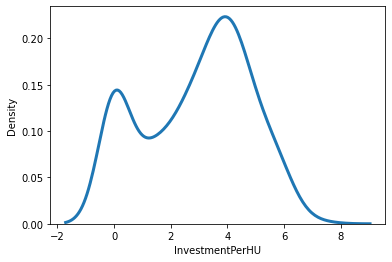

In [83]:
sns.distplot(ResInv['InvestmentPerHU'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})

eval_env: 1


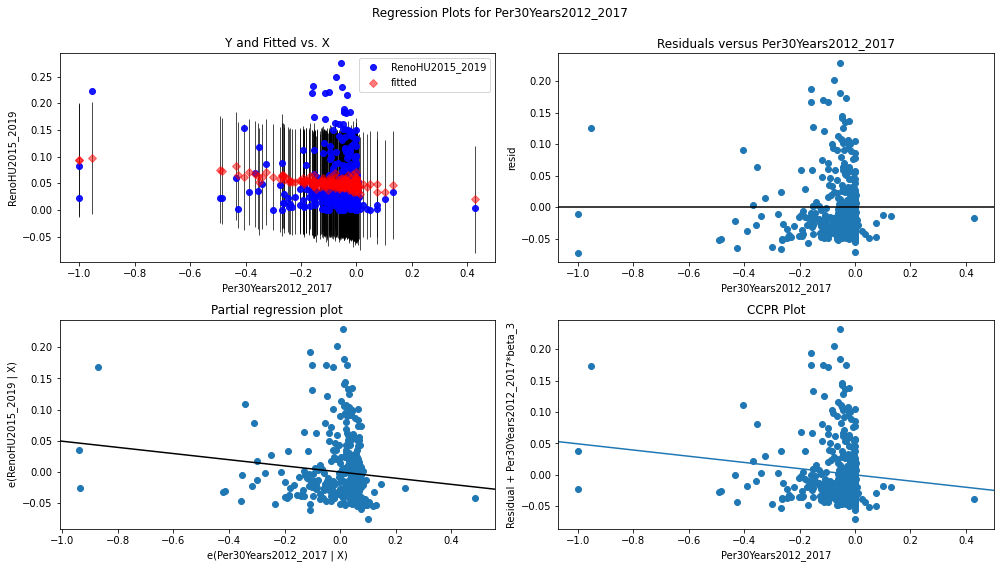

In [84]:
fig = plt.figure(figsize=(14, 8))

fig = sm.graphics.plot_regress_exog(PerAggOLS, 'Per30Years2012_2017', fig = fig)

In [85]:
white_test = het_white(PerAggOLS.resid,  PerAggOLS.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

pd.DataFrame(dict(zip(labels, white_test)), index=[1])

,Test Statistic,Test Statistic p-value,F-Statistic,F-Test p-value
1,12.112967,0.597231,0.858531,0.60478
